In [1]:
def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

In [2]:
def get_topk_distribution(final_graph, track_visibility):

    
    edgelist = final_graph.es
    
    indegree_by_time = Counter([(e["time"], e.target) for e in edgelist])
    
    
        
    mapping_t_nodes_degree = {}
    
    for t,node in indegree_by_time:
        
        if t not in mapping_t_nodes_degree:
            
            mapping_t_nodes_degree[t] = {}
            
        
        new_deg = indegree_by_time[(t,node)] 
        
        mapping_t_nodes_degree[t][node] = new_deg
    
    df_incremental_degree = pd.DataFrame()
    
    
    for t in sorted(mapping_t_nodes_degree):
        
        one_df = pd.DataFrame(mapping_t_nodes_degree[t].items())
        
        one_df.columns = ["node", "iteration_%s"%t]
        
        one_df.set_index("node", inplace=True)
        
        one_df.sort_index(inplace=True)
 
    
        df_incremental_degree = pd.concat([df_incremental_degree, one_df], axis=1)
        
    df_incremental_degree.fillna(0,inplace=True)
    
    df_incremental_degree = df_incremental_degree.cumsum(1)
    
    mapping_degree_per_iter = df_incremental_degree.to_dict() 
    
    #return mapping_degree_per_iter

    all_the_dfs = {}
    
    for n_iter in range(20):
        

        """        
        recommended_sorted = sorted(track_visibility[n_iter].items(), key = lambda x: x[1], reverse=True)

        N = len(recommended_sorted)

        size_top20 = round(N*0.2)
        size_top10 = round(N*0.1)
        size_top5 = round(N*0.05)

        
        recommended_sorted_color = [final_graph.vs[n]["selected_attribute"] for (n,d) in recommended_sorted[:size_top20]]
        

        
        top_k_by_iteration[n_iter] = {}
        
                
        top_k_by_iteration[n_iter]["top5"] = Counter(recommended_sorted_color[:size_top5])[attribute]/size_top5
        
        top_k_by_iteration[n_iter]["top10"] = Counter(recommended_sorted_color[:size_top10])[attribute]/size_top10

        top_k_by_iteration[n_iter]["top20"] = Counter(recommended_sorted_color[:size_top20])[attribute]/size_top20
        """
        
        graph_degree = mapping_degree_per_iter["iteration_%s"%n_iter]
        
        visibility_per_node = track_visibility[n_iter]
        
        df_combined = pd.DataFrame([
            (n, graph_degree[n], visibility_per_node[n]) for n in graph_degree], columns=["node", "degree", "visibility"])

        df_combined.sort_values("visibility", inplace=True)
        df_combined["T"] = 1
        df_combined["T"] = df_combined["T"].cumsum()/len(df_combined)
        
        all_the_dfs[n_iter] = df_combined
        
    plt.show()
        
    return all_the_dfs

In [3]:
def visibility_by_top_k(attribute, final_graph):

    initial_indegree = {}
    
    edgelist = final_graph.es
    
    initial_indegree = Counter([e.target for e in edgelist if e["time"] == 0])
    
    
    initial_indegree = {ID : initial_indegree[ID] for ID in initial_indegree}

    sorted_initial_indegree = [n for n,d in sorted(initial_indegree.items(), key=lambda x: x[1])]

    N = len(sorted_initial_indegree)


    intervals_top_k = list(
        zip([round(x,2) for x in np.arange(0., 1., 0.1)], 
            [round(x,2) for x in np.arange(0.1, 1.1, 0.1)]))

    top_k_groups = {}

    for inf, sup in intervals_top_k:

        a, b = int(inf*N), int(sup*N)
        #print(a,b)

        top_k_groups[round(1-inf,2)] = sorted_initial_indegree[a:b]


    top_k_visibility = pd.DataFrame()

    
    
    
    for it in track_visibility:
        
        mapping_groups = {}
        
        for group in top_k_groups:

            mapping_groups[group] = sum([
                track_visibility[it][n] for n in top_k_groups[group]
                
            if final_graph.vs[n]["selected_attribute"] == attribute
            
            ])
            
       
        df = pd.DataFrame(mapping_groups.items())
        
        df.columns = ["top-k", "iteration_%s"%it]
        df.set_index("top-k", inplace=True)
        df.sort_index(inplace=True)
        
        top_k_visibility = pd.concat([top_k_visibility, df], axis=1)
        
        
        
    return top_k_visibility

In [4]:
import pickle
import os
import glob
import igraph
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore')

In [5]:
# config 

fn_networks = glob.glob("../../../../semi_sinthetic_graphs/out/synth/*")

mapping_fn = {
    '../../../../semi_sinthetic_graphs/out/synth/sim20-topk3-TUENTI-A16-s_m0.3-hm0.5-hM0.2': "G4",
    '../../../../semi_sinthetic_graphs/out/synth/sim20-topk3-TUENTI-A16-s_m0.1-hm0.4-hM0.0': "G1",
    '../../../../semi_sinthetic_graphs/out/synth/sim20-topk3-TUENTI-A16-s_m0.3-hm-0.25-hM0.0': "G3",
    '../../../../semi_sinthetic_graphs/out/synth/sim20-topk3-TUENTI-A16-s_m0.45-hm0.5-hM0.0': "G2"
}

fontsize = 35


from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = fontsize


new_labels = {
    "A": "top-1%" ,
    "B": "top-3%", 
    "C": "top-5%", 
    "D": "top-10%", 
    "E": "top-20%",
    "F": "top-30%",
    "G": "rest of the graph",
    
}

group_labels = {
    "A": 0.99 ,
    "B": 0.97, 
    "C": 0.95, 
    "D": 0.90, 
    "E": 0.80,
    "F": 0.7,
    "G": 0.

}



In [6]:
selected_combinations = [
    "/policy-fc_algoname-als/",
    "/policy-fc_algoname-salsa/",
    "/policy-fc_algoname-ada/",
    "/policy-fc_algoname-random/",
]

G4/policy-fc_algoname-als/
G4/policy-fc_algoname-salsa/


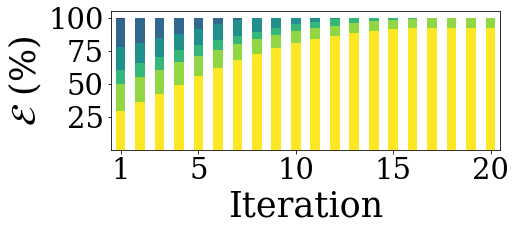

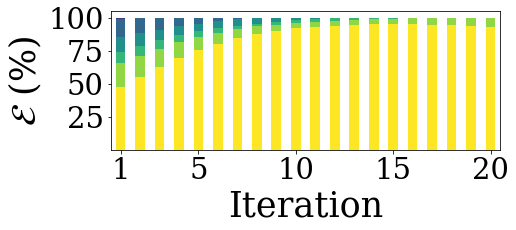

G4/policy-fc_algoname-ada/


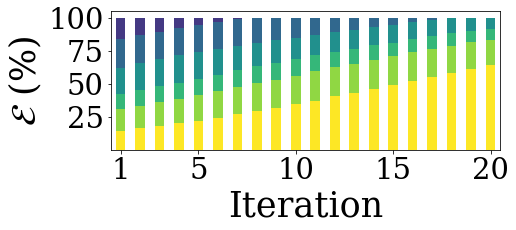

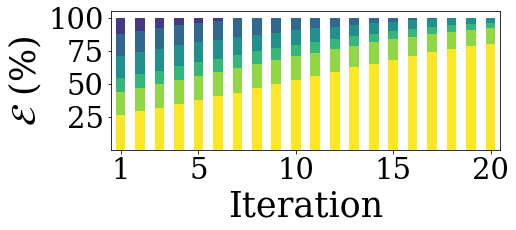

G4/policy-fc_algoname-random/


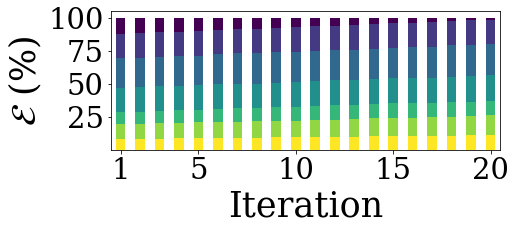

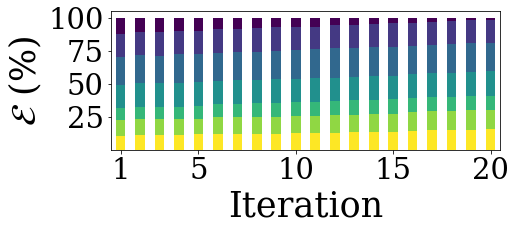

G1/policy-fc_algoname-als/


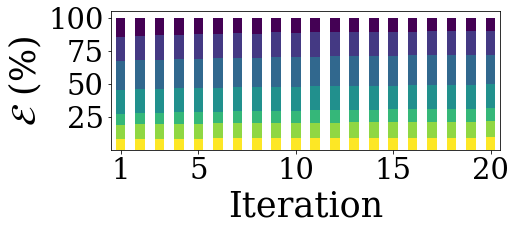

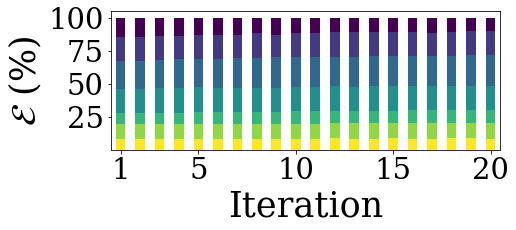

G1/policy-fc_algoname-salsa/


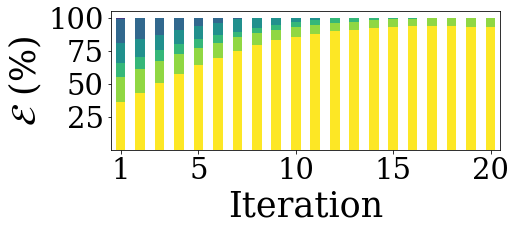

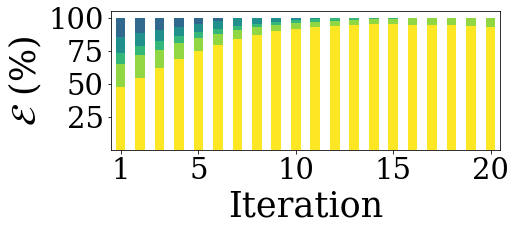

G1/policy-fc_algoname-ada/


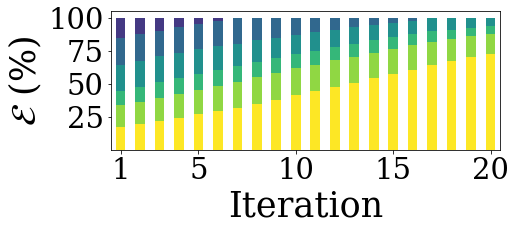

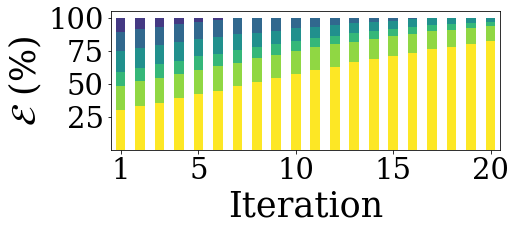

G1/policy-fc_algoname-random/


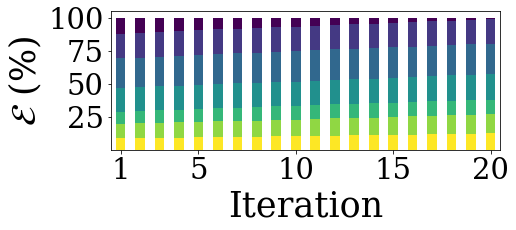

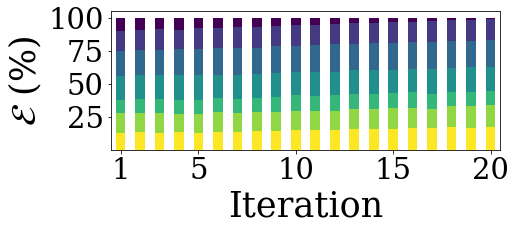

G3/policy-fc_algoname-als/


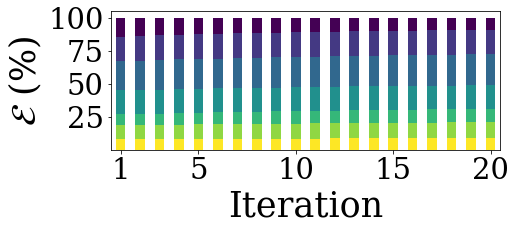

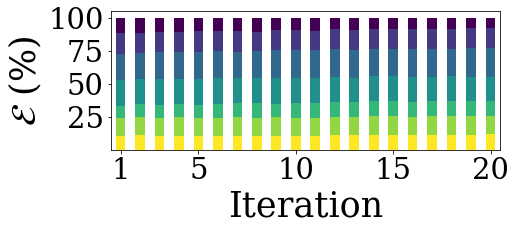

G3/policy-fc_algoname-salsa/


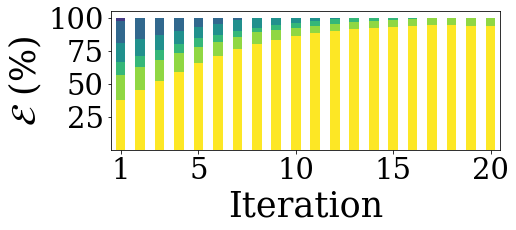

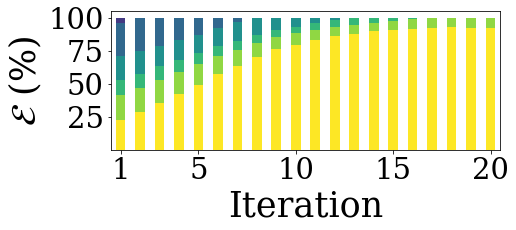

G3/policy-fc_algoname-ada/


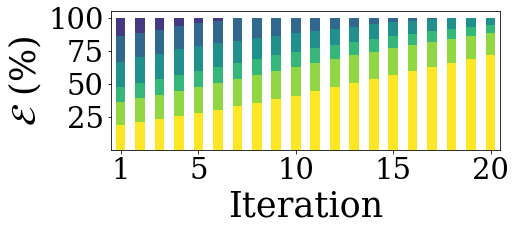

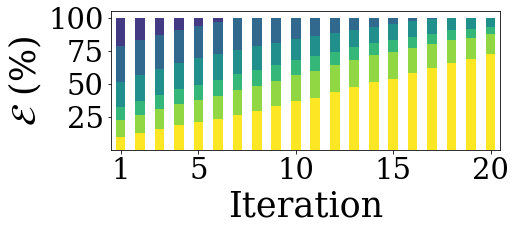

G3/policy-fc_algoname-random/


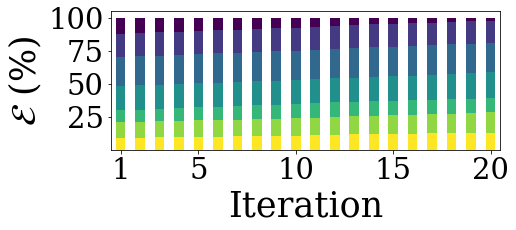

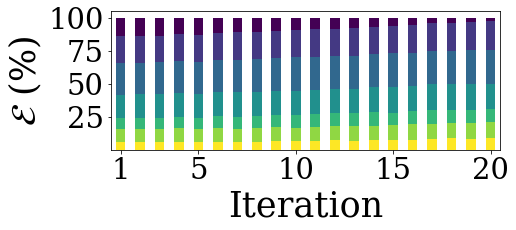

G2/policy-fc_algoname-als/


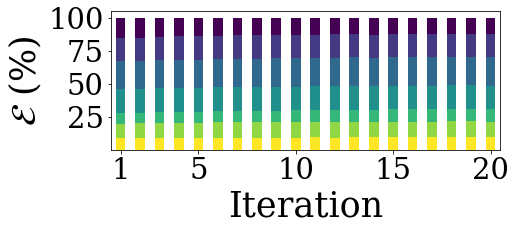

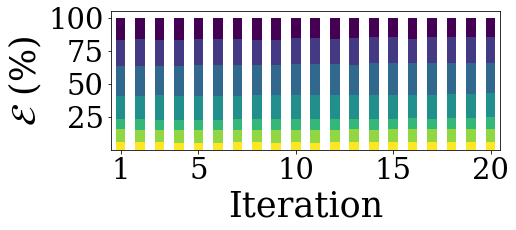

G2/policy-fc_algoname-salsa/


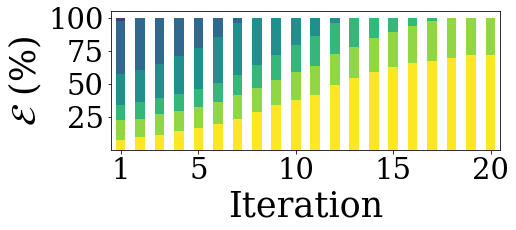

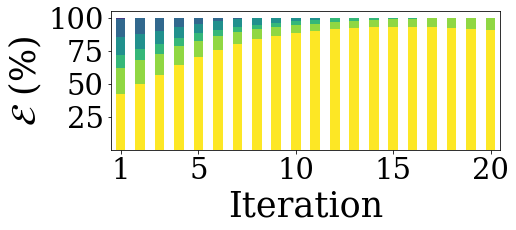

G2/policy-fc_algoname-ada/


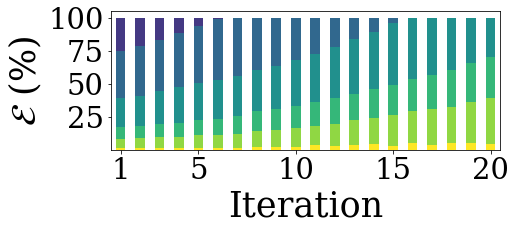

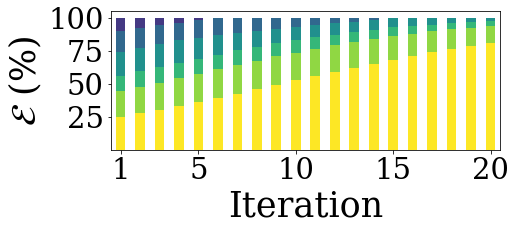

G2/policy-fc_algoname-random/


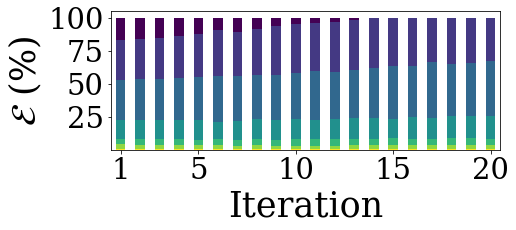

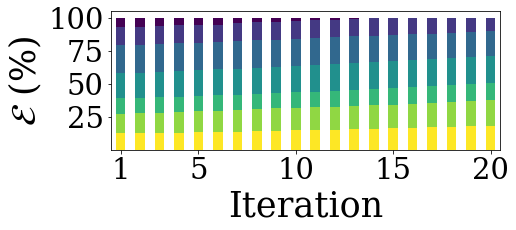

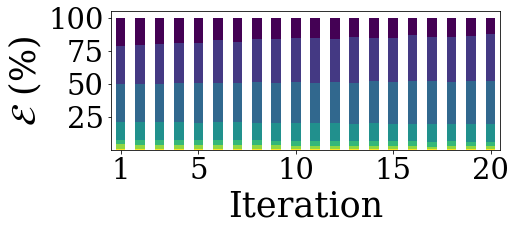

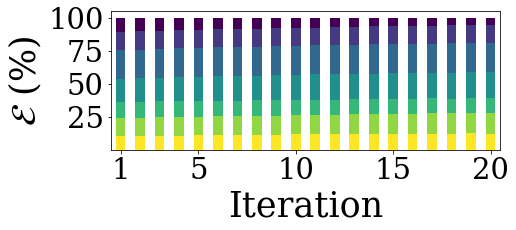

In [45]:
for selected_network in fn_networks:
    
    for combination in selected_combinations:
        
        print(mapping_fn[selected_network] + combination)
        

        with open(selected_network + combination + 'track_visibility_node.p', "rb") as f:
            track_visibility = pickle.load(f)

        with open(selected_network+ combination + "final-graph.p", "rb") as f:

            final_graph = pickle.load(f)


        all_the_dfs = get_topk_distribution(final_graph, track_visibility)

        for partition in ["majority", "minority"]:

            main_df = pd.DataFrame(0, index=range(1,21), columns=sorted(group_labels))

            for i in range(20):

                df = all_the_dfs[i].copy()
                df["attribute"] = df["node"].apply(lambda x: final_graph.vs[x]["selected_attribute"])

                #df["visibility"] = df["visibility"].apply(lambda x: np.log(x+1))

                df = df[(df["visibility"] > 0) & (df["attribute"] == partition)]

                df["labels"] = None

                for l in sorted(group_labels, reverse=True):

                    df["labels"][df["T"] > group_labels[l]] = l


                df_grouped = df.groupby("labels").sum()["visibility"]


                for l in df_grouped.index:


                    main_df.loc[i+1][l] = df_grouped[l]



            main_df = (main_df.T/main_df.sum(1)).T


            main_df.columns = [new_labels[l] for l in main_df.columns]

            main_df.plot.bar(stacked=True, cmap="viridis_r", legend=False, figsize=(8,4), fontsize=fontsize)
            #plt.legend(loc='best')

            plt.xticks([0, 4,9, 14,19], rotation=0, fontsize=fontsize-6)

            plt.yticks([.25, .50,.75, 1.],labels = [25, 50, 75, 100], rotation=0, fontsize=fontsize-6)

            plt.ylabel("$\mathcal{E}$ (%)")

            plt.xlabel("Iteration")

            plt.tight_layout()

            graphname = mapping_fn[selected_network]

            algo_and_policy = combination.replace("/","").replace("policy-", "").replace("algoname-", "")


            plt.savefig("%s-%s-%s.pdf"%(mapping_fn[selected_network], algo_and_policy, partition), format="pdf")

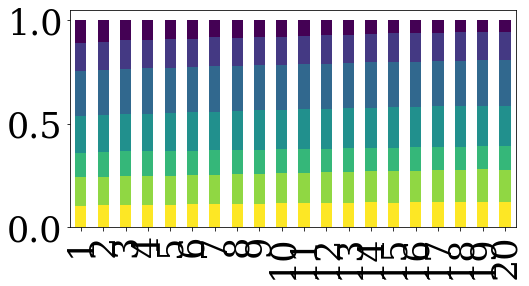

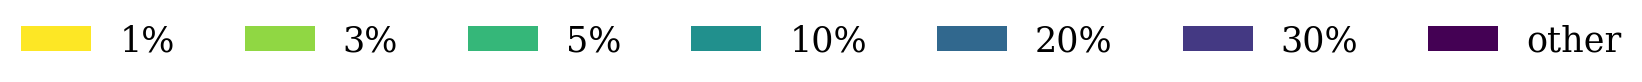

In [31]:
# create a figure with one subplot
fig = plt.figure()
ax = fig.add_subplot(111)

main_df.plot.bar(stacked=True, cmap="viridis_r", legend=False, figsize=(8,4), fontsize=fontsize,ax=ax)
# save it *without* adding a legend
#fig.savefig('image.png')

# then create a new image
# adjust the figure size as necessary
figsize = (25, 2)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
# add the legend from the previous axes

leginfo = ax.get_legend_handles_labels()
leginfo = (leginfo[0], [t.replace("top-","") for t in leginfo[1]][:-1] + ["other"])

ax_leg.legend(*leginfo, loc='center', ncol=7,frameon=False)
# hide the axes frame and the x/y labels
ax_leg.axis('off')
plt.tight_layout()
fig_leg.savefig('legend.pdf', format="pdf")